In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.models import convnext_base, convnext_tiny
import torch.optim as optim
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from PIL import Image
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, hamming_loss, mean_squared_error, mean_absolute_error, r2_score
import csv
import torch.nn.functional as F

### Read the two metadata files and concatenate them to form one metadata file.

In [2]:
# Load the metadata
metadata_cafe1 = pd.read_csv('nutrition5k_dataset/metadata/dish_metadata_cafe1.csv', sep=",", header=None, low_memory=False)
metadata_cafe2 = pd.read_csv('nutrition5k_dataset/metadata/dish_metadata_cafe2.csv', sep=",", header=None, low_memory=False)

# Combine the metadata
metadata = pd.concat([metadata_cafe1, metadata_cafe2], ignore_index=True)

print(metadata_cafe1.shape)
print(metadata_cafe2.shape)

(4768, 244)
(238, 153)


### Create a dataframe containing all the image paths (nutrition5k_dataset/imagery/realsense_overhead/dish_XXXXXXXXXX/rbg.png). 
### Merge this into the metadata dataframe to create a merged_data dataframe.

In [3]:
# Define the path to the imagery folder
image_base_path = 'nutrition5k_dataset/imagery/realsense_overhead/'

# Get all dish_ids from the imagery folder
image_paths = []
dish_ids = []
for root, dirs, files in os.walk(image_base_path):
    for file in files:
        if file == 'rgb.png':
            full_path = os.path.join(root, file)
            image_paths.append(full_path)
            dish_id = os.path.basename(root)  # Extract the dish_id
            dish_ids.append(dish_id)

# Create a DataFrame for the image paths and dish_ids
image_df = pd.DataFrame({
    'dish_id': dish_ids,
    'image_path': image_paths
})

# Rename the first column to 'dish_id' for clarity
metadata = metadata.rename(columns={metadata.columns[0]: 'dish_id'})

In [4]:
image_df.head()

,dish_id,image_path
0,dish_1565379827,nutrition5k_dataset/imagery/realsense_overhead...
1,dish_1563468269,nutrition5k_dataset/imagery/realsense_overhead...
2,dish_1563389786,nutrition5k_dataset/imagery/realsense_overhead...
3,dish_1561662458,nutrition5k_dataset/imagery/realsense_overhead...
4,dish_1559593794,nutrition5k_dataset/imagery/realsense_overhead...


### Preprocess the images for training in ConvNeXt. Images were loaded with PIL and need to be converted to RGB format, resized, and normalized.

In [5]:
# Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # Normalize with ImageNet mean and std
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Function to load and preprocess an image
def load_and_preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = transform(image)
    return image

### Create a tensor for the labels. Merge the metadata and image dataframes to form one frame.

In [6]:
nutritional_columns = [1, 2, 3, 4, 5]  # Adjust these indices based on your data
labels = metadata.iloc[:, nutritional_columns].values

# Convert labels to torch tensors
labels = torch.tensor(labels, dtype=torch.float32)

# Assuming dish_id is in column 0, merge with the image data
merged_data = pd.merge(left=metadata, right=image_df, how="inner", left_on="dish_id", right_on='dish_id')
print(merged_data.shape)
merged_data.head()

(3490, 245)


,dish_id,1,2,3,4,5,6,7,8,9,...,235,236,237,238,239,240,241,242,243,image_path
0,dish_1561662216,300.794281,193,12.387489,28.218290,18.633970,ingr_0000000508,soy sauce,3.398568,1.801241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
1,dish_1561662054,419.438782,292,23.838249,26.351543,25.910593,ingr_0000000312,pepper,0.300716,0.120286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
2,dish_1562008979,382.936646,290,22.224644,10.173570,35.345387,ingr_0000000448,jalapenos,0.192961,0.055959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
3,dish_1560455030,20.590000,103,0.148000,4.625000,0.956000,ingr_0000000471,cherry tomatoes,55.000000,9.900000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...
4,dish_1558372433,74.360001,143,0.286000,0.429000,20.020000,ingr_0000000453,deprecated,143.000000,74.360000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nutrition5k_dataset/imagery/realsense_overhead...


### Not all entries in the merged_data dataframe have an associated image. Here, the rows without an image are filtered out.

In [7]:
image_base_path = 'nutrition5k_dataset/imagery/realsense_overhead/'

def image_exists(image_path):
    return os.path.exists(image_path)

merged_data['image_exists'] = merged_data['image_path'].apply(image_exists)

filtered_data = merged_data[merged_data['image_exists'] == True].drop(columns=['image_exists'])
filtered_data.shape

(3490, 245)

### Starting with column 7 out to column 238, are the ingredients names. 

In [8]:
filtered_data.iloc[:,[7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126,133]] #

,7,14,21,28,35,42,49,56,63,70,77,84,91,98,105,112,119,126,133
0,soy sauce,garlic,white rice,parsley,onions,brown rice,vinegar,apple,mixed greens,sugar,salt,lemon juice,olive oil,pork,bok choy,pepper,millet,NaN,NaN
1,pepper,white rice,mixed greens,garlic,soy sauce,millet,lemon juice,bok choy,olive oil,onions,vinegar,green beans,pork,apple,sugar,salt,parsley,NaN,NaN
2,jalapenos,lemon juice,pork,wheat berry,cabbage,pepper,salt,carrot,garlic,caesar salad,olive oil,parsley,mayonnaise,NaN,NaN,NaN,NaN,NaN,NaN
3,cherry tomatoes,cucumbers,baby carrots,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,deprecated,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3485,cucumbers,celery,carrot,onions,apple cider,vinegar,broth,salt,pork,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3486,strawberries,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3487,broccoli,olive oil,bread crumbs,salt,jalapenos,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3488,scrambled eggs,roasted potatoes,crepes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Create a column in the filtered_data dataframe with a list of the unique ingredients for each row, all together. 

In [9]:
# Identify the columns related to ingredients
ingredient_columns = metadata.columns[6:]  # Ingredients start from column 6

# Function to parse ingredients for each dish
def parse_ingredients(row):
    ingredients = []
    # The first 6 columns are: dish_id (0), total_calories (1), total_mass (2), total_fat (3), total_carb (4), total_protein (5)
    num_ingredients = (len(row) - 6) // 7  # Each ingredient spans 7 columns
    for i in range(num_ingredients):
        idx = 6 + i * 7  # Starting index for each ingredient
        ingr_id = row[idx]
        ingr_name = row[idx + 1]
        ingr_grams = row[idx + 2]
        ingr_calories = row[idx + 3]
        ingr_fat = row[idx + 4]
        ingr_carb = row[idx + 5]
        ingr_protein = row[idx + 6]

        if pd.isna(ingr_name):
            continue  # Skip if ingredient name is NaN

        ingredients.append({
            'ingr_id': ingr_id,
            'ingr_name': str(ingr_name).strip().lower(),
            'ingr_grams': ingr_grams,
            'ingr_calories': ingr_calories,
            'ingr_fat': ingr_fat,
            'ingr_carb': ingr_carb,
            'ingr_protein': ingr_protein
        })
    return ingredients

# Apply the function to each row in filtered_data
filtered_data['ingredients'] = filtered_data.apply(parse_ingredients, axis=1)

### Read in the glycemic index data from the Excel spreadsheet. Create a dictionary to reference later.

In [10]:
# Load glycemic index data
glycemic_data = pd.read_excel('glycemic_index.xlsx')

# Clean ingredient names in glycemic data for consistent matching
glycemic_data['Item'] = glycemic_data['Item'].str.strip().str.lower()

# Create a mapping from ingredient name to glycemic index
glycemic_index_dict = glycemic_data.set_index('Item')['Glycemic index'].to_dict()

### From the list of ingredients and their masses, we can calculate the total glycemic index of the dish.

In [11]:
def calculate_weighted_gi(ingredients):
    total_mass = 0
    weighted_gi_sum = 0
    for ingr in ingredients:
        ingr_name = ingr['ingr_name']
        ingr_mass = ingr['ingr_grams']
        try:
            gi = glycemic_index_dict.get(ingr_name, None)
            if gi is not None and not pd.isna(ingr_mass):
                total_mass += ingr_mass
                weighted_gi_sum += gi * ingr_mass
        except KeyError:
            # Ingredient not found in glycemic index, skip or handle accordingly
            continue
    if total_mass > 0:
        weighted_gi = weighted_gi_sum / total_mass
    else:
        weighted_gi = np.nan  # Assign NaN if total_mass is zero
    return weighted_gi

# Apply the function to each dish
filtered_data['weighted_gi'] = filtered_data['ingredients'].apply(calculate_weighted_gi)

### Calculate the total number of unique ingredients. 

In [12]:
# Before splitting the data, build the global list of ingredients
ingredient_lists = filtered_data['ingredients'].apply(lambda x: [ingr['ingr_name'] for ingr in x])
all_ingredients_set = set()
for ingr_list in ingredient_lists:
    all_ingredients_set.update(ingr_list)
all_ingredients = sorted(list(all_ingredients_set))

# Create a shared LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_ingredients)
num_ingredients = len(all_ingredients)
print(f"Total number of unique ingredients: {num_ingredients}")

Total number of unique ingredients: 241


### Define NutritionDataset, which will collect the nutritional labels, ingredient labels, the weighted glycemic index. The ingredient list will be label binarized for training. 

In [54]:
class NutritionDataset(Dataset):
    def __init__(self, data, transform=None, all_ingredients=None, encoder=None):
        self.data = data.reset_index(drop=True)
        self.transform = transform

        # Use the provided all_ingredients and encoder
        self.all_ingredients = all_ingredients
        self.encoder = encoder

        # Ensure all_ingredients and encoder are provided
        if self.all_ingredients is None or self.encoder is None:
            raise ValueError("all_ingredients and encoder must be provided")

        # Binarize ingredient labels
        ingredient_lists = self.data['ingredients'].apply(lambda x: [ingr['ingr_name'] for ingr in x])
        self.data['ingredient_labels'] = ingredient_lists.apply(self.binarize_ingredients)

    def binarize_ingredients(self, ingredients):
        labels = np.zeros(len(self.all_ingredients), dtype=np.float32)
        valid_ingredients = [ingr for ingr in ingredients if ingr in self.encoder.classes_]
        indices = self.encoder.transform(valid_ingredients)
        labels[indices] = 1.0
        return labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load image
    # Load image using iloc
        img_path = self.data.iloc[idx]['image_path']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        # Get nutritional labels (columns 1 to 5)
        nutritional_labels = self.data.iloc[idx]['nutritional_labels']
        #nutritional_labels = self.data.iloc[idx][1, 2, 3, 4, 5].values.astype(np.float32)
        ingredient_labels = self.data.iloc[idx]['ingredient_labels']
        #weighted_gi = self.data.loc[idx, 'weighted_gi']
        weighted_gi = self.data.iloc[idx]['weighted_gi']

        if pd.isna(weighted_gi):
            weighted_gi = 0.0  # Assign a default value or handle appropriately
        weighted_gi = np.array([weighted_gi], dtype=np.float32)

        # Create label dictionary
        labels = {
            'nutritional_labels': torch.tensor(nutritional_labels),
            'ingredient_labels': torch.tensor(ingredient_labels),
            'weighted_gi': torch.tensor(weighted_gi)
        }

        return image, labels

### Split the data into train, validation and test sets. Create the dataloaders.

In [14]:
# Split the data
train_data, test_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create datasets using the shared all_ingredients and encoder
train_dataset = NutritionDataset(train_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)
val_dataset = NutritionDataset(val_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)
test_dataset = NutritionDataset(test_data, transform=transform, all_ingredients=all_ingredients, encoder=encoder)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

### Define the model using ConvNeXt. Define the optimizers, loss functions, and learning rate scheduler. 

In [15]:
from torchvision import models
from torchvision.models import ConvNeXt_Base_Weights

# Determine the device to run on (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class NutritionModel(nn.Module):
    def __init__(self, num_ingredients):
        super(NutritionModel, self).__init__()
        self.base_model = models.convnext_base(weights=ConvNeXt_Base_Weights.DEFAULT)   # Load pre-trained ConvNeXt Base model with updated weights parameter
        self.base_model.classifier = nn.Identity()    # Remove the default classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))   # Add AdaptiveAvgPool to reduce spatial dimensions
        
        # Define output layers
        self.fc_nutrition = nn.Linear(1024, 5)  # Output for nutritional values
        self.fc_ingredients = nn.Linear(1024, num_ingredients)  # Output for ingredient classification
        self.fc_weighted_gi = nn.Linear(1024, 1)  # Output for weighted glycemic index

    def forward(self, x):
        features = self.base_model(x)            # Features will have shape (batch_size, 1024, H, W)
        features = self.avgpool(features)        # Apply global average pooling to get (batch_size, 1024, 1, 1)
        features = torch.flatten(features, 1)    # Flatten the features to shape (batch_size, 1024)
        
        # # Pass through the output layers. Apply Softplus activation to enforce non-negativity
        nutrition_output = F.softplus(self.fc_nutrition(features))
        ingredient_output = torch.sigmoid(self.fc_ingredients(features))
        weighted_gi_output = F.softplus(self.fc_weighted_gi(features))
        
        return nutrition_output, ingredient_output, weighted_gi_output        

# Instantiate the model
model = NutritionModel(num_ingredients)
model = model.to(device)

# Define loss functions
criterion_nutrition   = nn.MSELoss()
criterion_ingredients = nn.BCELoss()
criterion_weighted_gi = nn.MSELoss()

# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

### Train the model.

In [19]:
# Training loop
num_epochs = 20

# Lists to store the average training and validation losses
train_losses = []
val_losses = []

# Lists for individual losses (optional)
train_nutrition_losses = []
train_ingredient_losses = []
train_gi_losses = []

val_nutrition_losses = []
val_ingredient_losses = []
val_gi_losses = []

# Lists to store metrics
val_precision_scores = []
val_recall_scores = []
val_f1_scores = []
val_hamming_losses = []

val_nutrition_mae = []
val_nutrition_rmse = []
val_nutrition_r2 = []

val_gi_mae = []
val_gi_rmse = []
val_gi_r2 = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_nutrition_loss = 0.0
    total_ingredient_loss = 0.0
    total_gi_loss = 0.0

    count = 0
    print(f"Starting training epoch: {epoch+1}/{num_epochs}              ")
    for images, labels in train_loader:
        # Move data to device
        images = images.to(device)
        nutritional_labels = labels['nutritional_labels'].to(device)
        ingredient_labels = labels['ingredient_labels'].to(device)
        weighted_gi_labels = labels['weighted_gi'].to(device)

        optimizer.zero_grad()

        # Forward pass
        nutrition_output, ingredient_output, weighted_gi_output = model(images)

        # Calculate losses
        loss_nutrition = criterion_nutrition(nutrition_output, nutritional_labels)
        loss_ingredients = criterion_ingredients(ingredient_output, ingredient_labels)
        loss_weighted_gi = criterion_weighted_gi(weighted_gi_output, weighted_gi_labels)

        # Combine losses (adjust weights if necessary)
        total_loss = loss_nutrition + loss_ingredients + loss_weighted_gi

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Accumulate losses
        running_loss += total_loss.item()
        total_nutrition_loss += loss_nutrition.item()
        total_ingredient_loss += loss_ingredients.item()
        total_gi_loss += loss_weighted_gi.item()

        count += 1
        print(f"Image {count}: loss = {total_loss.item()}", end="\r")

    # Calculate average training losses for the epoch
    avg_train_loss = running_loss / len(train_loader)
    avg_train_nutrition_loss = total_nutrition_loss / len(train_loader)
    avg_train_ingredient_loss = total_ingredient_loss / len(train_loader)
    avg_train_gi_loss = total_gi_loss / len(train_loader)

    # Append the average training loss to the list
    train_losses.append(avg_train_loss)
    train_nutrition_losses.append(avg_train_nutrition_loss)
    train_ingredient_losses.append(avg_train_ingredient_loss)
    train_gi_losses.append(avg_train_gi_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, "
          f"Nutrition Loss: {avg_train_nutrition_loss:.4f}, "
          f"Ingredient Loss: {avg_train_ingredient_loss:.4f}, "
          f"Weighted GI Loss: {avg_train_gi_loss:.4f}")

    # Validation loop
    print(f"Starting validation loop.")
    model.eval()
    val_loss = 0.0
    val_nutrition_loss = 0.0
    val_ingredient_loss = 0.0
    val_gi_loss = 0.0

    all_true_ingredient_labels = []
    all_predicted_ingredient_labels = []

    all_true_nutrition_labels = []
    all_predicted_nutrition_outputs = []

    all_true_weighted_gi_labels = []
    all_predicted_weighted_gi_outputs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            nutritional_labels = labels['nutritional_labels'].to(device)
            ingredient_labels = labels['ingredient_labels'].to(device)
            weighted_gi_labels = labels['weighted_gi'].to(device)

            # Forward pass
            nutrition_output, ingredient_output, weighted_gi_output = model(images)

            # Calculate losses
            loss_nutrition = criterion_nutrition(nutrition_output, nutritional_labels)
            loss_ingredients = criterion_ingredients(ingredient_output, ingredient_labels)
            loss_weighted_gi = criterion_weighted_gi(weighted_gi_output, weighted_gi_labels)

            total_loss = loss_nutrition + loss_ingredients + loss_weighted_gi

            # Accumulate validation losses
            val_loss += total_loss.item()
            val_nutrition_loss += loss_nutrition.item()
            val_ingredient_loss += loss_ingredients.item()
            val_gi_loss += loss_weighted_gi.item()

            # Move tensors to CPU and convert to numpy arrays
            # Ingredient labels
            true_ingredient_labels = ingredient_labels.cpu().numpy()
            predicted_ingredient_probs = ingredient_output.cpu().numpy()

            # Apply threshold to get binary predictions
            threshold = 0.5  # Adjust if necessary
            predicted_ingredient_labels = (predicted_ingredient_probs >= threshold).astype(int)

            # Accumulate ingredient labels
            all_true_ingredient_labels.append(true_ingredient_labels)
            all_predicted_ingredient_labels.append(predicted_ingredient_labels)

            # Nutritional outputs
            true_nutritional_labels = nutritional_labels.cpu().numpy()
            predicted_nutritional_outputs = nutrition_output.cpu().numpy()

            # Accumulate nutritional outputs
            all_true_nutrition_labels.append(true_nutritional_labels)
            all_predicted_nutrition_outputs.append(predicted_nutritional_outputs)

            # Weighted GI
            true_weighted_gi = weighted_gi_labels.cpu().numpy()
            predicted_weighted_gi = weighted_gi_output.cpu().numpy()

            # Accumulate weighted GI outputs
            all_true_weighted_gi_labels.append(true_weighted_gi)
            all_predicted_weighted_gi_outputs.append(predicted_weighted_gi)

            print(f"Validation loss = {total_loss.item()}              ")

    # Calculate average validation losses for the epoch
    avg_val_loss = val_loss / len(val_loader)
    avg_val_nutrition_loss = val_nutrition_loss / len(val_loader)
    avg_val_ingredient_loss = val_ingredient_loss / len(val_loader)
    avg_val_gi_loss = val_gi_loss / len(val_loader)

    # Append the average validation loss to the list
    val_losses.append(avg_val_loss)
    val_nutrition_losses.append(avg_val_nutrition_loss)
    val_ingredient_losses.append(avg_val_ingredient_loss)
    val_gi_losses.append(avg_val_gi_loss)

    # Concatenate accumulated arrays
    all_true_ingredient_labels = np.vstack(all_true_ingredient_labels)
    all_predicted_ingredient_labels = np.vstack(all_predicted_ingredient_labels)

    all_true_nutrition_labels = np.vstack(all_true_nutrition_labels)
    all_predicted_nutrition_outputs = np.vstack(all_predicted_nutrition_outputs)

    all_true_weighted_gi_labels = np.vstack(all_true_weighted_gi_labels)
    all_predicted_weighted_gi_outputs = np.vstack(all_predicted_weighted_gi_outputs)

    # Compute Classification Metrics for Ingredients
    ingredient_precision = precision_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
    ingredient_recall = recall_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
    ingredient_f1 = f1_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
    ingredient_hamming = hamming_loss(all_true_ingredient_labels, all_predicted_ingredient_labels)

    # Append metrics to lists
    val_precision_scores.append(ingredient_precision)
    val_recall_scores.append(ingredient_recall)
    val_f1_scores.append(ingredient_f1)
    val_hamming_losses.append(ingredient_hamming)

    # Compute Regression Metrics for Nutritional Information
    nutrition_mae = mean_absolute_error(all_true_nutrition_labels, all_predicted_nutrition_outputs)
    nutrition_mse = mean_squared_error(all_true_nutrition_labels, all_predicted_nutrition_outputs)
    nutrition_rmse = np.sqrt(nutrition_mse)
    nutrition_r2 = r2_score(all_true_nutrition_labels, all_predicted_nutrition_outputs, multioutput='variance_weighted')

    # Append nutrition metrics
    val_nutrition_mae.append(nutrition_mae)
    val_nutrition_rmse.append(nutrition_rmse)
    val_nutrition_r2.append(nutrition_r2)

    # Compute Regression Metrics for Weighted GI
    gi_mae = mean_absolute_error(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)
    gi_mse = mean_squared_error(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)
    gi_rmse = np.sqrt(gi_mse)
    gi_r2 = r2_score(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)

    # Append GI metrics
    val_gi_mae.append(gi_mae)
    val_gi_rmse.append(gi_rmse)
    val_gi_r2.append(gi_r2)

    # Print epoch statistics
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, "
          f"Nutrition Loss: {avg_val_nutrition_loss:.4f}, "
          f"Ingredient Loss: {avg_val_ingredient_loss:.4f}, "
          f"Weighted GI Loss: {avg_val_gi_loss:.4f}")
    print(f"Ingredient Precision: {ingredient_precision:.4f}, Recall: {ingredient_recall:.4f}, F1 Score: {ingredient_f1:.4f}, Hamming Loss: {ingredient_hamming:.4f}")
    print(f"Nutrition MAE: {nutrition_mae:.4f}, RMSE: {nutrition_rmse:.4f}, R²: {nutrition_r2:.4f}")
    print(f"GI MAE: {gi_mae:.4f}, RMSE: {gi_rmse:.4f}, R²: {gi_r2:.4f}\n")

    # Update the learning rate scheduler
    scheduler.step()

Starting training epoch: 1/20              
Epoch [1/20], Training Loss: 22562.6356, Nutrition Loss: 22064.5496, Ingredient Loss: 0.1968, Weighted GI Loss: 497.8890
Starting validation loop.
Validation loss = 18237.01171875              
Validation loss = 13511.87109375              
Validation loss = 12478.3623046875              
Validation loss = 11516.974609375              
Validation loss = 18465.271484375              
Validation loss = 17301.734375              
Validation loss = 13376.7529296875              
Validation loss = 12344.025390625              
Validation loss = 15985.7900390625              
Epoch [1/20], Validation Loss: 14801.9771, Nutrition Loss: 14303.4915, Ingredient Loss: 0.1182, Weighted GI Loss: 498.3676
Ingredient Precision: 0.4250, Recall: 0.0587, F1 Score: 0.0970, Hamming Loss: 0.0293
Nutrition MAE: 65.2497, RMSE: 119.4672, R²: -0.0081
GI MAE: 17.3873, RMSE: 22.2628, R²: -0.0049

Starting training epoch: 2/20              
Epoch [2/20], Training Loss: 1

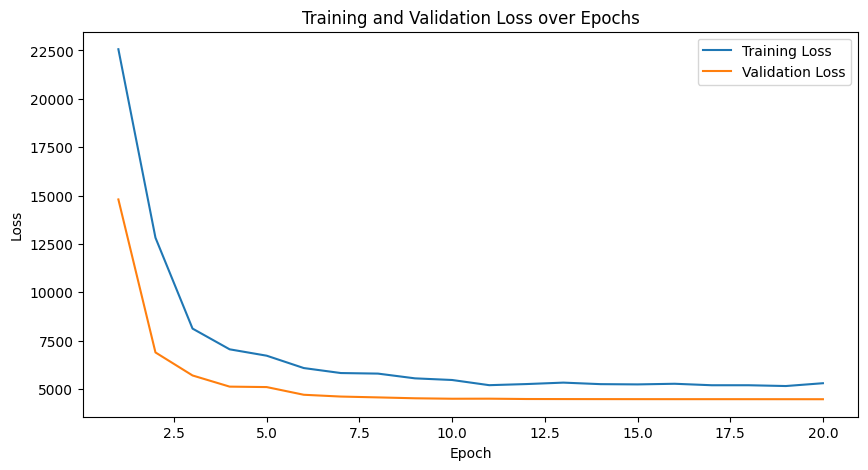

In [21]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Concatenate accumulated arrays
all_true_ingredient_labels = np.vstack(all_true_ingredient_labels)
all_predicted_ingredient_labels = np.vstack(all_predicted_ingredient_labels)

all_true_nutrition_labels = np.vstack(all_true_nutrition_labels)
all_predicted_nutrition_outputs = np.vstack(all_predicted_nutrition_outputs)

all_true_weighted_gi_labels = np.vstack(all_true_weighted_gi_labels)
all_predicted_weighted_gi_outputs = np.vstack(all_predicted_weighted_gi_outputs)

# Compute Classification Metrics for Ingredients
ingredient_precision = precision_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
ingredient_recall = recall_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
ingredient_f1 = f1_score(all_true_ingredient_labels, all_predicted_ingredient_labels, average='samples', zero_division=0)
ingredient_hamming_loss = hamming_loss(all_true_ingredient_labels, all_predicted_ingredient_labels)

# Compute Regression Metrics for Nutritional Information
nutrition_mae = mean_absolute_error(all_true_nutrition_labels, all_predicted_nutrition_outputs)
nutrition_mse = mean_squared_error(all_true_nutrition_labels, all_predicted_nutrition_outputs)
nutrition_rmse = np.sqrt(nutrition_mse)
nutrition_r2 = r2_score(all_true_nutrition_labels, all_predicted_nutrition_outputs, multioutput='variance_weighted')

# Compute Regression Metrics for Weighted GI
gi_mae = mean_absolute_error(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)
gi_mse = mean_squared_error(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)
gi_rmse = np.sqrt(gi_mse)
gi_r2 = r2_score(all_true_weighted_gi_labels, all_predicted_weighted_gi_outputs)

# Calculate average losses
avg_total_loss = val_loss / len(val_loader)
avg_nutrition_loss = total_nutrition_loss / len(val_loader)
avg_ingredient_loss = total_ingredient_loss / len(val_loader)
avg_gi_loss = total_gi_loss / len(val_loader)

print(f"Validation Results for Epoch {epoch+1}/{num_epochs}:")
print(f"Total Loss: {avg_total_loss:.4f}")
print(f"Nutritional Loss: {avg_nutrition_loss:.4f}")
print(f"Ingredient Loss: {avg_ingredient_loss:.4f}")
print(f"Weighted GI Loss: {avg_gi_loss:.4f}\n")

print("Ingredient Prediction Metrics:")
print(f"Precision: {ingredient_precision:.4f}")
print(f"Recall: {ingredient_recall:.4f}")
print(f"F1 Score: {ingredient_f1:.4f}")
print(f"Hamming Loss: {ingredient_hamming_loss:.4f}\n")

print("Nutritional Information Regression Metrics:")
print(f"MAE: {nutrition_mae:.4f}")
print(f"MSE: {nutrition_mse:.4f}")
print(f"RMSE: {nutrition_rmse:.4f}")
print(f"R² Score: {nutrition_r2:.4f}\n")

print("Weighted Glycemic Index Regression Metrics:")
print(f"MAE: {gi_mae:.4f}")
print(f"MSE: {gi_mse:.4f}")
print(f"RMSE: {gi_rmse:.4f}")
print(f"R² Score: {gi_r2:.4f}")

Validation Results for Epoch 20/20:
Total Loss: 4480.1050
Nutritional Loss: 43104.0767
Ingredient Loss: 0.8951
Weighted GI Loss: 3477.3380

Ingredient Prediction Metrics:
Precision: 0.2734
Recall: 0.0539
F1 Score: 0.0848
Hamming Loss: 0.0286

Nutritional Information Regression Metrics:
MAE: 32.1923
MSE: 3998.2910
RMSE: 63.2320
R² Score: 0.7176

Weighted Glycemic Index Regression Metrics:
MAE: 17.0097
MSE: 458.0713
RMSE: 21.4026
R² Score: 0.0713


In [23]:
# Testing loop
model.eval()
test_loss = 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        nutritional_labels = labels['nutritional_labels'].to(device)
        ingredient_labels = labels['ingredient_labels'].to(device)
        weighted_gi_labels = labels['weighted_gi'].to(device)

        # Forward pass
        nutrition_output, ingredient_output, weighted_gi_output = model(images)

        # Calculate losses
        loss_nutrition = criterion_nutrition(nutrition_output, nutritional_labels)
        loss_ingredients = criterion_ingredients(ingredient_output, ingredient_labels)
        loss_weighted_gi = criterion_weighted_gi(weighted_gi_output, weighted_gi_labels)

        total_loss = loss_nutrition + loss_ingredients + loss_weighted_gi
        test_loss += total_loss.item()

    # Print test statistics
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

Test Loss: 4171.8496


In [45]:
%pip install -q ipywidgets
import ipywidgets as widgets
from IPython.display import display, clear_output

Note: you may need to restart the kernel to use updated packages.


In [50]:
dish_ids = test_dataset.data['dish_id'].tolist()
image_paths = test_dataset.data['image_path'].tolist()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize using ImageNet's mean and std
                         std=[0.229, 0.224, 0.225])
])

# Extract image paths and dish IDs from test_dataset
dish_ids = test_dataset.data['dish_id'].tolist()
image_paths = test_dataset.data['image_path'].tolist()

# Create unique dropdown options
dropdown_options = [(f'{dish_id} ({idx})', image_path) 
                    for idx, (dish_id, image_path) in enumerate(zip(dish_ids, image_paths))]

# Define custom widths
dropdown_layout = widgets.Layout(width='400px')  # Adjust the overall width of the dropdown
dropdown_style = {'description_width': '150px'}  # Adjust the width of the label (caption)

# Create the dropdown widget with custom layout and style
image_selector = widgets.Dropdown(
    options=dropdown_options,
    description='Select Image:',
    layout=dropdown_layout,
    style=dropdown_style
)

# Create an output widget with a custom layout
out = widgets.Output(layout={'border': '1px solid black', 'width': '600px'})

def on_select_image(change):
    with out:
        clear_output(wait=True)
        image_path = change['new']
        
        try:
            # Load the image
            image = Image.open(image_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {e}")
            return
        
        # Preprocess the image
        input_image = transform(image).unsqueeze(0).to(device)
        
        # Make predictions
        with torch.no_grad():
            nutrition_output, ingredient_output, weighted_gi_output = model(input_image)
        
        # Process outputs
        nutrition_output = nutrition_output.cpu().numpy().squeeze(0)
        weighted_gi = weighted_gi_output.item()
        
        ingredient_probs = ingredient_output.cpu().numpy().squeeze(0)
        threshold = 0.2  # Adjust this threshold based on your validation results
        predicted_indices = np.where(ingredient_probs >= threshold)[0]
        predicted_ingredients = encoder.inverse_transform(predicted_indices)
        
        # Display the image
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Selected Image')
        plt.show()
        
        # Display predictions
        print("Predicted Ingredients:")
        for ingredient in predicted_ingredients:
            print(f"- {ingredient}")
        
        total_calories, total_mass, total_fat, total_carb, total_protein = nutrition_output
        
        print("\nNutritional Information:")
        print(f"Total Calories: {total_calories:.2f} kcal")
        print(f"Total Mass: {total_mass:.2f} grams")
        print(f"Total Fat: {total_fat:.2f} grams")
        print(f"Total Carbohydrates: {total_carb:.2f} grams")
        print(f"Total Protein: {total_protein:.2f} grams")
        
        print(f"\nWeighted Glycemic Index: {weighted_gi:.2f}")

# Attach the handler to the dropdown
image_selector.observe(on_select_image, names='value')

# Display the dropdown and output widget
display(image_selector, out)

# Manually call the handler to display predictions for the first image
if dropdown_options:
    initial_image_path = dropdown_options[0][1]
    on_select_image({'new': initial_image_path})

Dropdown(description='Select Image:', layout=Layout(width='400px'), options=(('dish_1558032156 (0)', 'nutritio…

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

In [58]:
print(f"Length of train_dataset: {len(train_dataset)}")
# Access the first item
image, labels = train_dataset[0]
print("First item accessed successfully.")

# Access the last item
image, labels = train_dataset[len(train_dataset) - 1]
print("Last item accessed successfully.")

Length of train_dataset: 2512
First item accessed successfully.
Last item accessed successfully.


In [61]:
ingredient_counts = np.zeros(len(encoder.classes_), dtype=np.float32)

try:
    for idx in range(len(train_dataset)):
        _, labels = train_dataset[idx]
        ingredient_counts += labels['ingredient_labels'].numpy()
    print("Ingredient counts calculated successfully.")
except Exception as e:
    print(f"Error calculating ingredient counts: {e}")

# Assuming 'train_dataset' is your training dataset
ingredient_names = encoder.inverse_transform(np.arange(len(ingredient_counts)))
ingredient_freq = list(zip(ingredient_names, ingredient_counts))
ingredient_freq.sort(key=lambda x: x[1], reverse=True)

# Print the top 10 most frequent ingredients
print("Top 10 Ingredients by Frequency:")
for ingr, count in ingredient_freq[:10]:
    print(f"{ingr}: {count}")

Ingredient counts calculated successfully.
Top 10 Ingredients by Frequency:
olive oil: 1192.0
salt: 1069.0
garlic: 717.0
vinegar: 550.0
pepper: 532.0
onions: 531.0
lemon juice: 445.0
arugula: 392.0
parsley: 370.0
cherry tomatoes: 368.0


In [51]:
# Save the model
torch.save(model.state_dict(), 'nutrition_model.pth')

# To load the model later
# model = NutritionModel(num_ingredients)
# model.load_state_dict(torch.load('nutrition_model.pth'))
# model = model.to(device)